# EMアルゴリズムによる階層的混合エキスパートモデルの学習

[Jordan and Jacobes, 1994](https://www.cs.toronto.edu/~hinton/absps/hme.pdf) で提案されている、EMアルゴリズムによる階層的混合エキスパートモデルの学習を実装する。

## 階層的混合エキスパートモデルの概要

説明変数のデータセットを $X$、目的変数のデータセットを $Y$ とおく。<br>
また、データセットの各要素の添え字を $t$、データセットの各要素を $\mathbf{x}^{(t)}$、$\mathbf{y}^{(t)}$ と表す。<br>
$\mathbf{x}^{(t)}$ は $m$ 次元、$\mathbf{y}^{(t)}$ は $n$ 次元の実数から成るベクトルである。<br>
データセットはそれぞれ、$X$ は各行が ${\mathbf{x}^{(t)}}^{T}$、$Y$ は各行が ${\mathbf{y}^{(t)}}^{T}$ から成る行列とする。

このとき、$\mathbf{x}^{(t)}$ から $\mathbf{y}^{(t)}$ を予測するモデルとして、以下のような階層的なモデルを考える。<br>
このモデルは階層的混合エキスパートモデル (Hierarchical Mixtures of Experts, HME) として知られている。<br>
葉に置かれた expert network それぞれで $\mathbf{x}^{(t)}$ から $\mathbf{y}^{(t)}$ の予測値を求め、<br>
求めた予測値のうち最終的な予測値として採用するものをエッジに置かれた gating network で選択する。<br>
選択はソフトに行う (各 gating network が出力する確率による重み付き和を最終的な予測値とする)。

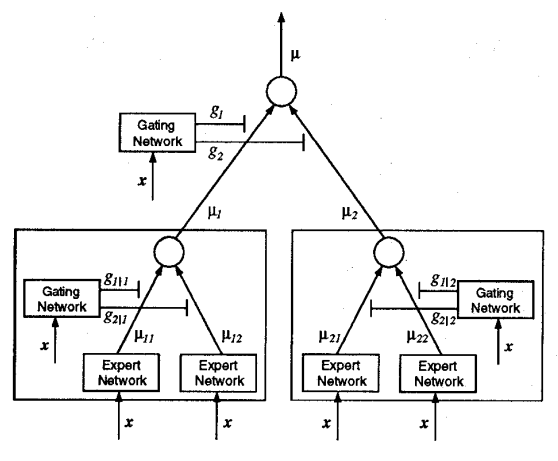

[Jordan and Jacobes, 1994](https://www.cs.toronto.edu/~hinton/absps/hme.pdf) より Figure 1を引用。

## 階層的混合エキスパートモデルの定式化と学習に必要な式の導出

[Jordan and Jacobes, 1994](https://www.cs.toronto.edu/~hinton/absps/hme.pdf) に従い、2階層の階層的混合エキスパートモデルをEMアルゴリズムで学習させる方法を定式化する。<br>
EMアルゴリズムは、潜在変数 $Z$ を含むモデルのパラメータ $\theta$ を、<br>
以下に示すEステップとMステップを繰り返すことにより求める方法である。

* Eステップ
    * 現在のパラメータ $\theta^{(p)}$ を用いて $P\left(Z\mid Y,\theta^{(p)}\right)$ を求める。
* Mステップ
    * $\theta^{(p+1)}=\mathop{\mathrm{argmax}}_{\theta}{Q\left(\theta,\theta^{(p)}\right)}$ でパラメータを更新する。
    * ただし、$Q\left(\theta,\theta^{(p)}\right)=\sum_{Z}{P\left(Z\mid Y,\theta^{(p)}\right)\ln{P\left(Y,Z\mid \theta\right)}}$ とする。

本節では、階層的混合エキスパートモデルを定式化した後、<br>
EMアルゴリズムに必要な ${P\left(Y,Z\mid \theta\right)}$、$P\left(Z\mid Y,\theta^{(p)}\right)$、$Q\left(\theta,\theta^{(p)}\right)$ を導出する。

### 階層的混合エキスパートモデルの定式化

1階層目の分岐の添え字を $i$、2階層目の分岐の添え字を $j$ とおく。<br>
また、1階層目の gating network の出力を $g_{i}$、2階層目の gating network の出力を $g_{j\mid i}$ とおく。<br>
$g_{i}$ と $g_{j\mid i}$ は、それぞれ次の式で与えられる。

$$
\begin{align}
g_{i}^{(t)}
&=\mathop{\mathrm{softmax}}\left(\mathbf{v}_{i}^{T}\mathbf{x}^{(t)}\right) \\
g_{j\mid i}^{(t)}
&=\mathop{\mathrm{softmax}}\left(\mathbf{v}_{ij}^{T}\mathbf{x}^{(t)}\right)
\end{align}
$$

各 expart network が出力する予測値を $\mathbf{\mu}_{ij}^{(t)}$、2階層目における予測値を $\mathbf{\mu}_{i}^{(t)}$、1階層目における予測値 (最終的な予測値) を $\mathbf{\mu}^{(t)}$ とおく。<br>
$\mathbf{\mu}_{ij}^{(t)}$、$\mathbf{\mu}_{i}^{(t)}$、$\mathbf{\mu}^{(t)}$ は、それぞれ次の式で与えられる。

$$
\begin{align}
\mathbf{\mu}_{ij}^{(t)}
&=f\left(U_{ij}\mathbf{x}^{(t)}\right) \\
\mathbf{\mu}_{i}^{(t)}
&=\sum_{j}{g_{j\mid i}^{(t)}\mathbf{\mu}_{ij}^{(t)}} \\
\mathbf{\mu}^{(t)}
&=\sum_{i}{g_{i}^{(t)}\mathbf{\mu}_{i}^{(t)}}
\end{align}
$$

さらに、各 expert network における $\mathbf{y}^{(t)}$ の確率分布を $P_{ij}\left(\mathbf{y}^{(t)}\right)$ とおく。<br>
本 notebook では、$f$ を恒等写像、$P_{ij}$ を正規分布と設定した次の場合について考える。

$$
P_{ij}\left(\mathbf{y}^{(t)}\right)=\mathcal{N}\left(\mathbf{y}^{(t)}\mid\mathbf{\mu}_{ij}^{(t)},\Sigma_{ij}\right)=\mathcal{N}\left(\mathbf{y}^{(t)}\mid U_{ij}\mathbf{x}^{(t)},\Sigma_{ij}\right)
$$

以上から、本 notebook で扱う階層的混合エキスパートモデルに含まれる全パラメータの集合 $\theta$ は次のようになる。

$$
\theta=\left\{\mathbf{v}_{i},\mathbf{v}_{ij},U_{ij},\Sigma_{ij}\mid i\in\left\{1,2\right\},j\in\left\{1,2\right\}\right\}
$$

### $Y$ と $Z$ の同時分布 $P\left(Y,Z\mid\theta\right)$ の導出

ここで、潜在変数 $z_{ij}^{(t)}$ を導入する。<br>
$z_{ij}^{(t)}$ は、データ点 $\mathbf{x}^{(t)}$ に対する予測値として expert netowork $ij$ が選ばれた場合に $1$、選ばれなかった場合に $0$ を取る。<br>
$\mathbf{z}^{(t)}$ を各成分が $z_{ij}^{(t)}$ から成るベクトル、$Z$ を各行が ${\mathbf{z}^{(t)}}^{T}$ から成る行列とおく。

$Y$ と $Z$ の同時分布は次のようになる。

$$
\begin{align}
P\left(Y,Z\mid\theta\right)
&=\prod_{t}{P\left(\mathbf{y}^{(t)},\mathbf{z}^{(t)}\right)} \\
&=\prod_{t}{P\left(\mathbf{z}^{(t)}\right)P\left(\mathbf{y}^{(t)}\mid \mathbf{z}^{(t)}\right)}
\end{align}
$$

$z_{ij}^{(t)}$ の事前確率は根から expert network $ij$ までの経路上にある gating network の積だから、$\mathbf{z}^{(t)}$ の事前確率は次のようになる。

$$
P\left(\mathbf{z}^{(t)}\right)
=\prod_{i}{\prod_{j}{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}\right)^{z_{ij}^{(t)}}}}
$$

また、各 expert network における $\mathbf{y}^{(t)}$ の確率分布を $P_{ij}\left(\mathbf{y}^{(t)}\right)$ とおいたので、$\mathbf{z}^{(t)}$ が与えられたときの $\mathbf{y}^{(t)}$ の確率分布は次のようになる。

$$
P\left(\mathbf{y}^{(t)}\mid \mathbf{z}^{(t)}\right)
=\prod_{i}{\prod_{j}{P_{ij}\left(\mathbf{y}^{(t)}\right)^{z_{ij}^{(t)}}}}
$$

したがって、同時分布は次のように表せる。

$$
P\left(Y,Z\mid\theta\right)
=\prod_{t}{\prod_{i}{\prod_{j}{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)\right)^{z_{ij}^{(t)}}}}}
$$

### $Z$ の事後分布 $P\left(Z\mid Y,\theta\right)$ の導出

$Y$ と $Z$ の同時分布から、$Z$ の事後分布を求める。<br>
$Z$ の事後分布は次のようになる。

$$
\begin{align}
P\left(Z\mid Y,\theta\right)
&=\frac{p\left(Y,Z\mid\theta\right)}{P\left(Y\mid\theta\right)} \\
&=\frac{p\left(Y,Z\mid\theta\right)}{\sum_{Z}{p\left(Y,Z\mid\theta\right)}} \\
&=\frac{\prod_{t}{\prod_{i}{\prod_{j}{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)\right)^{z_{ij}^{(t)}}}}}}{\sum_{Z}{\prod_{t}{\prod_{i}{\prod_{j}{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)\right)^{z_{ij}^{(t)}}}}}}}
\end{align}
$$

分母に現れる $Z$ の周辺化は煩雑なため、具体的な計算例を示しながら説明する。<br>
まず、すべての $Z$ の集合を $\zeta$、$\zeta$ の各要素の添え字を $s$、各要素を $Z^{(s)}$ とおく。<br>
ただし、$\zeta$ は通常の集合ではなく、横ベクトルに変形した $Z^{(s)}=\left(z_{11}^{(t)(s)},\ldots,z_{22}^{(t)(s)}\right)$ を縦に並べた行列とする。<br>
以下に、データ点の数が $2$ のときの $\zeta$ の例を示す。

|添え字/記号|項1|項2|項3|項4|項5|項6|項7|項8|
|--:|--:|--:|--:|--:|--:|--:|--:|--:|
|$t$|1|1|1|1|2|2|2|2|
|$i$|1|1|2|2|1|1|2|2|
|$j$|1|2|1|2|1|2|1|2|
|$z_{ij}^{(t)(1)}$|1|0|0|0|1|0|0|0|
|$z_{ij}^{(t)(2)}$|1|0|0|0|0|1|0|0|
|$z_{ij}^{(t)(3)}$|1|0|0|0|0|0|1|0|
|$z_{ij}^{(t)(4)}$|1|0|0|0|0|0|0|1|
|$z_{ij}^{(t)(5)}$|0|1|0|0|1|0|0|0|
|$z_{ij}^{(t)(6)}$|0|1|0|0|0|1|0|0|
|$z_{ij}^{(t)(7)}$|0|1|0|0|0|0|1|0|
|$z_{ij}^{(t)(8)}$|0|1|0|0|0|0|0|1|
|$z_{ij}^{(t)(9)}$|0|0|1|0|1|0|0|0|
|$z_{ij}^{(t)(10)}$|0|0|1|0|0|1|0|0|
|$z_{ij}^{(t)(11)}$|0|0|1|0|0|0|1|0|
|$z_{ij}^{(t)(12)}$|0|0|1|0|0|0|0|1|
|$z_{ij}^{(t)(13)}$|0|0|0|1|1|0|0|0|
|$z_{ij}^{(t)(14)}$|0|0|0|1|0|1|0|0|
|$z_{ij}^{(t)(15)}$|0|0|0|1|0|0|1|0|
|$z_{ij}^{(t)(16)}$|0|0|0|1|0|0|0|1|

$\sum_{Z}{p\left(Y,Z\mid\theta\right)}$ は、$Z^{(1)}$ ～ $Z^{(16)}$ のそれぞれについて $p\left(Y,Z^{(s)}\mid\theta\right)$ を計算し総和をとることで求められる。

$$
\sum_{Z}{p\left(Y,Z\mid\theta\right)}
=\sum_{s}{p\left(Y,Z^{(s)}\mid\theta\right)}
$$

$\zeta$ は $\mathbf{z}^{(1)}$ (4通り) と  $\mathbf{z}^{(2)}$ (4通り) の組み合わせ (16通り) から構成されているため、<br>
総和は $\mathbf{z}^{(1)}$ の値ごとに4つに分けて計算することができる。

$$
\begin{align}
\sum_{Z}{p\left(Y,Z\mid\theta\right)}
&=\sum_{s=1}^{4}{p\left(Y,Z^{(s)}\mid\theta\right)}
+\sum_{s=5}^{8}{p\left(Y,Z^{(s)}\mid\theta\right)}
+\sum_{s=9}^{12}{p\left(Y,Z^{(s)}\mid\theta\right)}
+\sum_{s=13}^{16}{p\left(Y,Z^{(s)}\mid\theta\right)}
\end{align}
$$

第1項の $1\le s\le 4$ の場合を計算すると、次のようになる。第2項以降も、同様の計算結果が得られる。

$$
\begin{align}
\sum_{s=1}^{4}{p\left(Y,Z^{(s)}\mid\theta\right)}
&=g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)
g_{1}^{(2)}g_{1\mid 1}^{(2)}P_{11}\left(\mathbf{y}^{(2)}\right) \\
&\hspace{2em}+g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)
g_{1}^{(2)}g_{2\mid 1}^{(2)}P_{12}\left(\mathbf{y}^{(2)}\right) \\
&\hspace{4em}+g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)
g_{2}^{(2)}g_{1\mid 2}^{(2)}P_{21}\left(\mathbf{y}^{(2)}\right) \\
&\hspace{6em}+g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)
g_{2}^{(2)}g_{2\mid 2}^{(2)}P_{22}\left(\mathbf{y}^{(2)}\right) \\
&=g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)\sum_{i}{\sum_{j}{g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)}}
\end{align}
$$

この計算結果を元の式に代入する。

$$
\begin{align}
\sum_{Z}{p\left(Y,Z\mid\theta\right)}
&=g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)\sum_{i}{\sum_{j}{g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)}} \\
&\hspace{2em}+g_{1}^{(1)}g_{2\mid 1}^{(1)}P_{12}\left(\mathbf{y}^{(1)}\right)\sum_{i}{\sum_{j}{g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)}} \\
&\hspace{4em}+g_{2}^{(1)}g_{1\mid 2}^{(1)}P_{21}\left(\mathbf{y}^{(1)}\right)\sum_{i}{\sum_{j}{g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)}} \\
&\hspace{6em}+g_{2}^{(1)}g_{2\mid 2}^{(1)}P_{22}\left(\mathbf{y}^{(1)}\right)\sum_{i}{\sum_{j}{g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)}}
\end{align}
$$

各項の共通因数をくくりだす。

$$
\sum_{Z}{p\left(Y,Z\mid\theta\right)}
=\left(\sum_{i}{\sum_{j}{g_{i}^{(1)}g_{j\mid i}^{(1)}P_{ij}\left(\mathbf{y}^{(1)}\right)}}\right)
\left(\sum_{i}{\sum_{j}{g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)}}\right)
$$

総乗として表しなおす。

$$
\sum_{Z}{p\left(Y,Z\mid\theta\right)}
=\prod_{t}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}}
$$

したがって、$Z$ の事後確率は次のように表せる。

$$
P\left(Z\mid Y,\theta\right)
=\frac{\prod_{t}{\prod_{i}{\prod_{j}{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)\right)^{z_{ij}^{(t)}}}}}}{\prod_{t}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}}}
$$

### $Q\left(\theta,\theta^{(p)}\right)$ の導出

定式化の最後に、Mステップで最大化する $Q\left(\theta,\theta^{(p)}\right)$ を求める。

$$
Q\left(\theta,\theta^{(p)}\right)
=\sum_{Z}{P\left(Z\mid Y,\theta^{(p)}\right)\ln{P\left(Y,Z\mid \theta\right)}}
$$

対数尤度関数は次のようになる。

$$
\ln{P\left(Y,Z\mid\theta\right)}
=\sum_{t}{\sum_{i}{\sum_{j}{z_{ij}^{(t)}\ln{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)\right)}}}}
$$

これを元の式に代入する。

$$
Q\left(\theta,\theta^{(p)}\right)
=\sum_{Z}{\left(P\left(Z\mid Y,\theta^{(p)}\right)\sum_{t}{\sum_{i}{\sum_{j}{z_{ij}^{(t)}\ln{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)\right)}}}}\right)}
$$

ここで、$a^{(s)}=P\left(Z^{(s)}\mid Y,\theta^{(p)}\right)$、$\mathbf{a}$ を各成分が $a^{(s)}$ から成るベクトルとおく。<br>
同様に、$l_{ij}^{(t)}=\ln{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)\right)}$、$\mathbf{l}$ を各成分が $l_{ij}^{(t)}$ から成るベクトルとおく。<br>
すると、$Q\left(\theta,\theta^{(p)}\right)$ は $\mathbf{a}$、$\zeta$、$\mathbf{l}$ の積として表せる。

$$
Q\left(\theta,\theta^{(p)}\right)
=\mathbf{a}^{T}\left(\zeta\mathbf{l}\right)
$$

積の順序を入れ替えることができる。<br>
$\mathbf{a}^{T}\zeta$ は、各成分が $z_{ij}^{(t)}$ の期待値から成るベクトルを表す。<br>
このことから、$Q\left(\theta,\theta^{(p)}\right)$ を求めるには、まず $z_{ij}^{(t)}$ の期待値を求めればよい。

$$
Q\left(\theta,\theta^{(p)}\right)
=\left(\mathbf{a}^{T}\zeta\right)\mathbf{l}
$$

$z_{ij}^{(t)}$ の期待値の計算も煩雑なため、$Z$ の事後分布の導出時と同じ例を用いて具体的に説明する。<br>
まず、$z_{ij}^{(t)}$ の期待値は次の式で計算できる。

$$
\mathbb{E}\left[z_{ij}^{(t)}\right]=\sum_{s}{a^{(s)}z_{ij}^{(t)(s)}}
$$

一例として $z_{11}^{(1)}$ の期待値を計算すると、$z_{11}^{(1)(s)}=1$ を満たす $1\le s\le 4$ の項のみが残るため、計算結果は次のようになる。

$$
\begin{align}
\mathbb{E}\left[z_{11}^{(1)}\right]
&=\frac{\left(g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)\right)\left(g_{1}^{(2)}g_{1\mid 1}^{(2)}P_{11}\left(\mathbf{y}^{(2)}\right)\right)}{\prod_{t}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}}} \\
&\hspace{2em}+\frac{\left(g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)\right)\left(g_{1}^{(2)}g_{2\mid 1}^{(2)}P_{12}\left(\mathbf{y}^{(2)}\right)\right)}{\prod_{t}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}}} \\
&\hspace{4em}+\frac{\left(g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)\right)\left(g_{2}^{(2)}g_{1\mid 2}^{(2)}P_{21}\left(\mathbf{y}^{(2)}\right)\right)}{\prod_{t}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}}} \\
&\hspace{6em}+\frac{\left(g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)\right)\left(g_{2}^{(2)}g_{2\mid 2}^{(2)}P_{22}\left(\mathbf{y}^{(2)}\right)\right)}{\prod_{t}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}}}
\end{align}
$$

各項の共通因子をくくりだす。

$$
\mathbb{E}\left[z_{11}^{(1)}\right]
=\frac{g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)}{\prod_{t}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}}}\sum_{i}{\sum_{j}{\left(g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)\right)}}
$$

分母の $t$ に関する総乗を書き下し、約分する。

$$
\begin{align}
\mathbb{E}\left[z_{11}^{(1)}\right]
&=\frac{g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)}{\left(\sum_{i}{\sum_{j}{g_{i}^{(1)}g_{j\mid i}^{(1)}P_{ij}\left(\mathbf{y}^{(1)}\right)}}\right)\left(\sum_{i}{\sum_{j}{g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)}}\right)}\sum_{i}{\sum_{j}{\left(g_{i}^{(2)}g_{j\mid i}^{(2)}P_{ij}\left(\mathbf{y}^{(2)}\right)\right)}} \\
&=\frac{g_{1}^{(1)}g_{1\mid 1}^{(1)}P_{11}\left(\mathbf{y}^{(1)}\right)}{\sum_{i}{\sum_{j}{g_{i}^{(1)}g_{j\mid i}^{(1)}P_{ij}\left(\mathbf{y}^{(1)}\right)}}} 
\end{align}
$$

この式の右辺は、$\mathbf{y}^{(1)}$ が与えられたときの $z_{11}^{(1)}$ の事後分布を表している。

$$
\mathbb{E}\left[z_{11}^{(1)}\right]
=P\left(z_{11}^{(1)}\mid\mathbf{y}^{(1)}\right)
$$

同様の手順で計算すると、$z_{ij}^{(t)}$ の期待値は次のようになる。

$$
\mathbb{E}\left[z_{ij}^{(t)}\right]
=P\left(z_{ij}^{(t)}\mid\mathbf{y}^{(t)}\right)
$$

したがって、$Q\left(\theta,\theta^{(p)}\right)$ は次のように表せる。<br>
ここで、表記を簡潔に保つため $h_{ij}^{(t)}=P\left(z_{ij}^{(t)}\mid\mathbf{y}^{(t)}\right)$ とおいた。

$$
Q\left(\theta,\theta^{(p)}\right)
=\sum_{t}{\sum_{i}{\sum_{j}{h_{ij}^{(t)}\ln{\left(g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)\right)}}}}
$$

なお、この後の $Q\left(\theta,\theta^{(p)}\right)$ の極大化の準備として、積の $\ln$ を $\ln$ の和に変換しておく。

$$
Q(\theta,\theta^{(p)})
=\sum_{t}{\sum_{i}{\sum_{l}{h_{ij}^{(t)}\ln{g_{i}^{(t)}}}}} +
\sum_{t}{\sum_{i}{\sum_{l}{h_{ij}^{(t)}\ln{g_{j\mid i}^{(t)}}}}} +
\sum_{t}{\sum_{i}{\sum_{l}{h_{ij}^{(t)}\ln{P_{ij}(\mathbf{y}^{(t)})}}}}
$$

## Mステップにおける1階層目の gating network のパラメータ $\mathbf{v}_i$ の求め方

$\mathbf{v}_i$ の極大解を解析的に求めることはできないため、ニュートン法で極大解を求める。<br>
この方法は反復再重み付き最小二乗法として知られている (cf. PRML 4.3.3 反復再重み付き最小二乗)。

$$
\mathbf{v}_{i}^{(\mathrm{new})}
=\mathbf{v}_{i}^{(\mathrm{old})}+\left(\nabla\nabla Q\left(\theta,\theta^{(p)}\right)\right)^{-1}\nabla Q\left(\theta,\theta^{(p)}\right)
$$

### 事後分布 $h_{ij}$ の分解

$\nabla Q\left(\theta,\theta^{(p)}\right)$ を導出する過程で $h_{ij}$ を層別に分解する必要があるため、準備として先に分解しておく。

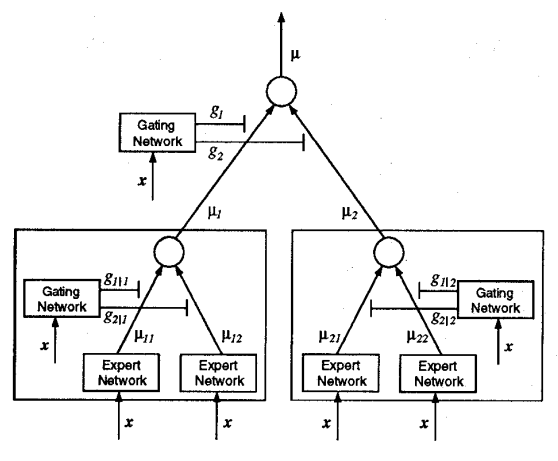

[Jordan and Jacobes, 1994](https://www.cs.toronto.edu/~hinton/absps/hme.pdf) より Figure 1を引用。

$Q\left(\theta,\theta^{(p)}\right)$ を導出する過程で示したように、<br>
木全体における、データ点が与えられたときの潜在変数の事後分布は次のように表せる。

$$
h_{ij}^{(t)}
=\frac{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}} 
$$

一方で、図の枠で囲われた部分木を一つの大きな expart network だとみなすと、次の事後分布が得られる。

$$
h_{i}^{(t)}
=\frac{g_{i}^{(t)}\sum_{j}{g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}{\sum_{i}{\sum_{j}{g_{i}^{(t)}g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}}
$$

同様に、図の枠で囲われた部分木に注目すると、次の事後確率が得られる。

$$
h_{j\mid i}^{(t)}
=\frac{g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}{\sum_{j}{g_{j\mid i}^{(t)}P_{ij}\left(\mathbf{y}^{(t)}\right)}}
$$

式を見比べると、木全体の事後確率は、部分木を大きな expart network とみなした場合の事後確率に、<br>
部分木の事後確率を掛け合わせたものになっていることがわかる。

$$
h_{ij}^{(t)}=h_{i}^{(t)}h_{j\mid i}^{(t)}
$$

### $\nabla Q\left(\theta,\theta^{(p)}\right)$ の導出

$Q\left(\theta,\theta^{(p)}\right)$ を $\mathbf{v}_{i}$ で微分する。<br>
ここで、微分の対象を指す添え字と総和の対象を指す添え字の衝突を防ぐため、総和の対象を指す添え字 $i$ を $k$ に、$j$ を $l$ に置き換える。

$$
\begin{align}
\nabla Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\mathbf{v}_{i}}Q\left(\theta,\theta^{(p)}\right) \\
&=\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{k}^{(t)}}}}} +
\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{l\mid k}^{(t)}}}}} +
\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{P_{kl}\left(\mathbf{y}^{(t)}\right)}}}}
\end{align}
$$

第1項以外は $\mathbf{v}_{i}$ を含まないため、消去する。

$$
\nabla Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{k}^{(t)}}}}}
$$

$h_{kl}^{(t)}=h_{k}^{(t)}h_{l\mid k}^{(t)}$ を用いて、$l$ に関する総和を消去する。<br>
なお、$g_{k}^{(t)}$ は $k\ne i$ であってもソフトマックス関数の分母に $\mathbf{v}_{i}$ を含んでいるため、$k$ に関する総和は消去できない。

$$
\begin{align}
\nabla Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{\sum_{k}{\sum_{l}{h_{k}^{(t)}h_{l\mid k}^{(t)}\ln{g_{k}^{(t)}}}}} \\
&=\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{\sum_{k}{h_{k}^{(t)}\ln{g_{k}^{(t)}}\sum_{l}{h_{l\mid k}^{(t)}}}} \\
&=\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{\sum_{k}{h_{k}^{(t)}\ln{g_{k}^{(t)}}}}
\end{align}
$$

$k$ に関する総和を書き下し、微分作用素を展開する。<br>
ここでは二分木を想定しているため、$k$ に関する総和は $k=i$ のときと $k\ne i$ のときの和になる。

$$
\begin{align}
\nabla Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{\left(h_{k=i}^{(t)}\ln{g_{k=i}^{(t)}}+h_{k\ne i}^{(t)}\ln{g_{k\ne i}^{(t)}}\right)} \\
&=\sum_{t}{\left(h_{k=i}^{(t)}\frac{\partial}{\mathbf{v}_{i}}\ln{g_{k=i}^{(t)}}+h_{k\ne i}^{(t)}\frac{\partial}{\mathbf{v}_{i}}\ln{g_{k\ne i}^{(t)}}\right)} \\
\end{align}
$$

右辺を $\mathbf{v}_{i}$ で微分し、整理する。<br>
$y_{i}=\mathop{\mathrm{softmax}}(x_{i})$ の微分が、$i=j$ のとき $\frac{\partial y_{i}}{\partial x_{j}}=y_{i}(1-y_{i})$、$i\ne j$ のとき $\frac{\partial y_{i}}{\partial x_{j}}=-y_{i}y_{j}$ となることを用いる。

$$
\begin{align}
\nabla Q\left(\theta,\theta^{(p)}\right)
&=\sum_{t}{\left(h_{k=i}^{(t)}\frac{1}{g_{k=i}^{(t)}}g_{k=i}^{(t)}\left(1-g_{k=i}^{(t)}\right)\mathbf{x}^{(t)}+h_{k\ne i}^{(t)}\frac{1}{g_{k\ne i}^{(t)}}\left(-g_{k=i}^{(t)}g_{k\ne i}^{(t)}\right)\mathbf{x}^{(t)}\right)} \\
&=\sum_{t}{\left(h_{k=i}^{(t)}\left(1-g_{k=i}^{(t)}\right)\mathbf{x}^{(t)}-h_{k\ne i}^{(t)}g_{k=i}^{(t)}\mathbf{x}^{(t)}\right)} \\
&=\sum_{t}{\left(h_{k=i}^{(t)}-\left(h_{k=i}^{(t)}+h_{k\ne i}^{(t)}\right)g_{k=i}^{(t)}\right)\mathbf{x}^{(t)}} \\
&=\sum_{t}{\left(h_{k=i}^{(t)}-g_{k=i}^{(t)}\right)\mathbf{x}^{(t)}} \\
&=\sum_{t}{\left(h_{i}^{(t)}-g_{i}^{(t)}\right)\mathbf{x}^{(t)}}
\end{align}
$$

$\mathbf{h}_{i}$ を各成分が ${h_{i}^{(t)}}$ から成るベクトル、$\mathbf{g}_{i}$ を各成分が $g_{i}^{(t)}$ から成るベクトルとおき、右辺を整理する。

$$
\nabla Q\left(\theta,\theta^{(p)}\right)
=-X^{T}\left(\mathbf{g}_{i}-\mathbf{h}_{i}\right)
$$

### $\nabla\nabla Q\left(\theta,\theta^{(p)}\right)$ の導出

$\nabla Q\left(\theta,\theta^{(p)}\right)$ を $\mathbf{v}_{i}$ で微分する。

$$
\begin{align}
\nabla\nabla Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\mathbf{v}_{i}}\left(\nabla Q\left(\theta,\theta^{(p)}\right)\right) \\
&=\frac{\partial}{\mathbf{v}_{i}}\left(\sum_{t}{\left(h_{i}^{(t)}-g_{i}^{(t)}\right)\mathbf{x}^{(t)}}\right) \\
&=\frac{\partial}{\mathbf{v}_{i}}\left(\sum_{t}{h_{i}^{(t)}\mathbf{x}^{(t)}}-\sum_{t}{g_{i}^{(t)}\mathbf{x}^{(t)}}\right)
\end{align}
$$

第1項は $\mathbf{v}_{i}$ を含まないため、消去する。

$$
\nabla\nabla Q\left(\theta,\theta^{(p)}\right)
=-\frac{\partial}{\mathbf{v}_{i}}\sum_{t}{g_{i}^{(t)}\mathbf{x}^{(t)}}
$$

右辺の各成分で勾配を計算し、ヘッセ行列を求める。

$$
\begin{align}
\nabla\nabla Q\left(\theta,\theta^{(p)}\right)
&=-\left(
    \begin{array}{ccc}
        \frac{\partial}{\mathbf{v}_{i}}\sum_{t}{g_{i}^{(t)}x_{1}^{(t)}} &
        \ldots &
        \frac{\partial}{\mathbf{v}_{i}}\sum_{t}{g_{i}^{(t)}x_{m}^{(t)}}
    \end{array}
\right) \\
&=-\left(
    \begin{array}{ccc}
        \sum_{t}{\left(g_{i}^{(t)}\left(1-g_{i}^{(t)}\right)\mathbf{x}^{(t)}\right)x_{1}^{(t)}} &
        \ldots &
        \sum_{t}{\left(g_{i}^{(t)}\left(1-g_{i}^{(t)}\right)\mathbf{x}^{(t)}\right)x_{m}^{(t)}}
    \end{array}
\right) \\
&=-\sum_{t}{\left(
    \begin{array}{ccc}
        \left(g_{i}^{(t)}\left(1-g_{i}^{(t)}\right)\mathbf{x}^{(t)}\right)x_{1}^{(t)} &
        \ldots &
        \left(g_{i}^{(t)}\left(1-g_{i}^{(t)}\right)\mathbf{x}^{(t)}\right)x_{m}^{(t)}
    \end{array}
\right)} \\
&=-\sum_{t}{\left(g_{i}^{(t)}\left(1-g_{i}^{(t)}\right)\mathbf{x}^{(t)}\right){\mathbf{x}^{(t)}}^{T}}
\end{align}
$$

$R_{i}$ を対角成分が $g_{i}^{(t)}\left(1-g_{i}^{(t)}\right)$ から成る対角行列とおき、右辺を整理する。

$$
\nabla\nabla Q\left(\theta,\theta^{(p)}\right)
=-X^{T}R_{i}X
$$

### 更新式の導出

更新式に求めた $\nabla Q\left(\theta,\theta^{(p)}\right)$ と $\nabla\nabla Q\left(\theta,\theta^{(p)}\right)$ を代入して整理し、最終的な更新式を得る。

$$
\begin{align}
\mathbf{v}_{i}^{(\mathrm{new})}
&=\mathbf{v}_{i}^{(\mathrm{old})}+\left(\nabla\nabla Q\left(\theta,\theta^{(p)}\right)\right)^{-1}\nabla Q\left(\theta,\theta^{(p)}\right) \\
&=\mathbf{v}_{i}^{(\mathrm{old})}+\left(-X^{T}R_{i}X\right)^{-1}\left(-X^{T}\left(\mathbf{g}_{i}-\mathbf{h}_{i}\right)\right) \\
&=\mathbf{v}_{i}^{(\mathrm{old})}+\left(X^{T}R_{i}X\right)^{-1}X^{T}\left(\mathbf{g}_{i}-\mathbf{h}_{i}\right)
\end{align}
$$

なお、この更新式による解法が反復再重み付き最小二乗法と呼ばれる理由を示すために、<br>
更新式を重み付き最小二乗法の正規方程式の形に変形する。

$$
\begin{align}
\mathbf{v}_{i}^{(\mathrm{new})}
&=\left(X^{T}R_{i}X\right)^{-1}\left(\left(X^{T}R_{i}X\right)\mathbf{v}_{i}^{(\mathrm{old})}+X^{T}\left(\mathbf{g}_{i}-\mathbf{h}_{i}\right)\right) \\
&=\left(X^{T}R_{i}X\right)^{-1}X^{T}R_{i}\left(X\mathbf{v}_{i}^{(\mathrm{old})}+R_{i}^{-1}\left(\mathbf{g}_{i}-\mathbf{h}_{i}\right)\right)
\end{align}
$$

$\mathbf{z}=X\mathbf{v}_{i}^{(\mathrm{old})}+R_{i}^{-1}\left(\mathbf{g}_{i}-\mathbf{h}_{i}\right)$ とおく (PRMLの表記に倣った結果、記号が被ってしまったが、隠れ変数とは関係ない)。

$$
\mathbf{v}_{i}^{(\mathrm{new})}=\left(X^{T}R_{i}X\right)^{-1}X^{T}R_{i}\mathbf{z}
$$

この式から、更新式が $R_{i}$ で重み付けした重み付き最小二乗法の正規方程式になっていることがわかる。<br>
ただし、$R_{i}$ は定数ではなく $\mathbf{v}_{i}$ に依存しているため、$\mathbf{v}_{i}$ を更新するたびに $R_{i}$ も更新し正規方程式を解きなおす必要がある。<br>
これが理由で、この更新式による解法は反復再重み付き最小二乗法と呼ばれている。

## Mステップにおける2階層目の gating network のパラメータ $\mathbf{v}_{ij}$ の求め方

ここでは、$\mathbf{v}_{ij}$ を $\mathbf{v}_{i}$ と同様の手順で導出できることを示す。<br>
$\mathbf{v}_{i}$ と同様に、$\mathbf{v}_{ij}$ の極大解を解析的に求めることはできないため、ニュートン法で極大解を求める。<br>


$$
\mathbf{v}_{ij}^{(\mathrm{new})}=\mathbf{v}_{ij}^{(\mathrm{old})}+\left(\nabla\nabla Q\left(\theta,\theta^{(p)}\right)\right)^{-1}\nabla Q\left(\theta,\theta^{(p)}\right)
$$

### $\nabla Q\left(\theta,\theta^{(p)}\right)$ の導出

$Q\left(\theta,\theta^{(p)}\right)$ を $\mathbf{v}_{ij}$ で微分する。<br>
ここで、微分の対象を指す添え字と総和の対象を指す添え字の衝突を防ぐため、総和の対象を指す添え字 $i$ を $k$ に、$j$ を $l$ に置き換える。

$$
\begin{align}
\nabla Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\mathbf{v}_{ij}}Q\left(\theta,\theta^{(p)}\right) \\
&=\frac{\partial}{\mathbf{v}_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{k}^{(t)}}}}} +
\frac{\partial}{\mathbf{v}_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{l\mid k}^{(t)}}}}} +
\frac{\partial}{\mathbf{v}_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{P_{kl}\left(\mathbf{y}^{(t)}\right)}}}}
\end{align}
$$

第2項以外は $\mathbf{v}_{ij}$ を含まないため、消去する。

$$
\nabla Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\mathbf{v}_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{l\mid k}^{(t)}}}}}
$$

総和のうち $k=i$ 以外の項は $\mathbf{v}_{ij}$ を含まないため、消去する。<br>
なお、$g_{l\mid k}^{(t)}$ は $l \ne j$ であってもソフトマックス関数の分母に $\mathbf{v}_{ij}$ を含んでいるため、$l$ に関する総和は消去できない。

$$
\nabla Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\mathbf{v}_{ij}}\sum_{t}{\sum_{l}{h_{il}^{(t)}\ln{g_{l\mid i}^{(t)}}}}
$$

$h_{il}^{(t)}=h_{i}^{(t)}h_{l\mid i}^{(t)}$ を用いて、$h_{il}^{(t)}$ を分解する。

$$
\begin{align}
\nabla Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\mathbf{v}_{ij}}\sum_{t}{\sum_{l}{h_{i}^{(t)}h_{l\mid i}^{(t)}\ln{g_{l\mid i}^{(t)}}}} \\
&=\frac{\partial}{\mathbf{v}_{ij}}\sum_{t}{h_{i}^{(t)}\sum_{l}{h_{l\mid i}^{(t)}\ln{g_{l\mid i}^{(t)}}}}
\end{align}
$$

$l$ に関する総和を書き下し、微分作用素を展開する。<br>
ここでは二分木を想定しているため、$l$ に関する総和は $l=j$ のときと $l\ne j$ のときの和になる。

$$
\begin{align}
\nabla Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\mathbf{v}_{ij}}\sum_{t}{h_{i}^{(t)}\left(h_{l=j\mid i}^{(t)}\ln{g_{l=j\mid i}^{(t)}}+h_{l\ne j\mid i}^{(t)}\ln{g_{l\ne j\mid i}^{(t)}}\right)} \\
&=\sum_{t}{h_{i}^{(t)}\left(h_{l=j\mid i}^{(t)}\frac{\partial}{\mathbf{v}_{ij}}\ln{g_{l=j\mid i}^{(t)}}+h_{l\ne j\mid i}^{(t)}\frac{\partial}{\mathbf{v}_{ij}}\ln{g_{l\ne j\mid i}^{(t)}}\right)}
\end{align}
$$

この式は $\mathbf{v}_{i}$ の $\nabla Q\left(\theta,\theta^{(p)}\right)$ と同じ形のため、$\mathbf{v}_{i}$ と同じ手順で求められる。<br>
$H_{i}$ を対角成分が $h_{i}^{(t)}$ から成る対角行列、
$\mathbf{h}_{j\mid i}$ を各成分が ${h_{j\mid i}^{(t)}}$ から成るベクトル、$\mathbf{g}_{j\mid i}$ を各成分が $g_{j\mid i}^{(t)}$ から成るベクトルとおくと、<br>$\mathbf{v}_{ij}$ の $\nabla Q\left(\theta,\theta^{(p)}\right)$ は次のようになる。

$$
\nabla Q\left(\theta,\theta^{(p)}\right)
=-X^{T}H_{i}\left(\mathbf{g}_{j\mid i}-\mathbf{h}_{j\mid i}\right)
$$

### $\nabla\nabla Q\left(\theta,\theta^{(p)}\right)$ の導出

$\nabla Q\left(\theta,\theta^{(p)}\right)$ と同様に、$\nabla\nabla Q\left(\theta,\theta^{(p)}\right)$ も $\mathbf{v}_{i}$ と同じ手順で求められる。<br>
$R_{j\mid i}$ を対角成分が $g_{j\mid i}^{(t)}\left(1-g_{j\mid i}^{(t)}\right)$ から成る対角行列とおくと、<br>$\mathbf{v}_{ij}$ の $\nabla\nabla Q\left(\theta,\theta^{(p)}\right)$ は次のようになる。

$$
\nabla\nabla Q\left(\theta,\theta^{(p)}\right)
=-X^{T}H_{i}R_{j\mid i}X
$$

### 更新式の導出

更新式に求めた $\nabla Q\left(\theta,\theta^{(p)}\right)$ と $\nabla\nabla Q\left(\theta,\theta^{(p)}\right)$ を代入して整理し、最終的な更新式を得る。

$$
\begin{align}
\mathbf{v}_{ij}^{(\mathrm{new})}
&=\mathbf{v}_{ij}^{(\mathrm{old})}+\left(\nabla\nabla Q\left(\theta,\theta^{(p)}\right)\right)^{-1}\nabla Q\left(\theta,\theta^{(p)}\right) \\
&=\mathbf{v}_{ij}^{(\mathrm{old})}+\left(-X^{T}H_{i}R_{j\mid i}X\right)^{-1}\left(-X^{T}H_{i}\left(\mathbf{g}_{j\mid i}-\mathbf{h}_{ij}\right)\right) \\
&=\mathbf{v}_{ij}^{(\mathrm{old})}+\left(X^{T}H_{i}R_{j\mid i}X\right)^{-1}X^{T}H_{i}\left(\mathbf{g}_{j\mid i}-\mathbf{h}_{ij}\right)
\end{align}
$$

## Mステップにおける expert network のパラメータ $U_{ij}$ と $\Sigma_{ij}$ の求め方

$U_{ij}$ と $\Sigma_{ij}$ の極大解は解析的に求めることができる (cf. PRML 9.3.1 混合ガウス分布再訪)。

### $U_{ij}$ の極大解の導出

$Q\left(\theta,\theta^{(p)}\right)$ を極大化する $U_{ij}$ を求めるために、$Q\left(\theta,\theta^{(p)}\right)$ を $U_{ij}$ で微分する。<br>
ここで、微分の対象を指す添え字と総和の対象を指す添え字の衝突を防ぐため、総和の対象を指す添え字 $i$ を $k$ に、$j$ を $l$ に置き換える。

$$
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial U_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{k}^{(t)}}}}} +
\frac{\partial}{\partial U_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{l\mid k}^{(t)}}}}} +
\frac{\partial}{\partial U_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{P_{kl}\left(\mathbf{y}^{(t)}\right)}}}}
$$

第3項以外は $U_{ij}$ を含まないため、消去する。

$$
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial U_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{P_{kl}\left(\mathbf{y}^{(t)}\right)}}}}
$$

$P_{ij}(\mathbf{y}^{(t)})=\mathcal{N}(\mathbf{y}^{(t)}\mid U_{ij}\mathbf{x}^{(t)},\Sigma_{ij})$ を用いて、$\ln$ の中を展開する。

$$
\begin{align}
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\partial U_{ij}}\sum_{t}{\sum_{i}{\sum_{j}{h_{kl}^{(t)}\ln{\mathcal{N}(\mathbf{y}^{(t)}\mid U_{kl}\mathbf{x}^{(t)},\Sigma_{kl})}}}} \\
&=\frac{\partial}{\partial U_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\left(-\frac{1}{2}\left(\mathbf{y}^{(t)}-U_{kl}\mathbf{x}^{(t)}\right)^T\Sigma_{kl}^{-1}\left(\mathbf{y}^{(t)}-U_{kl}\mathbf{x}^{(t)}\right)-\frac{n}{2}\ln{\left(2\pi\right)}-\frac{1}{2}\ln|\Sigma_{kl}|\right)}}}
\end{align}
$$

第2項と第3項は $U_{ij}$ を含まないため、消去する。

$$
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial U_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\left(-\frac{1}{2}\left(\mathbf{y}^{(t)}-U_{kl}\mathbf{x}^{(t)}\right)^T\Sigma_{kl}^{-1}\left(\mathbf{y}^{(t)}-U_{kl}\mathbf{x}^{(t)}\right)\right)}}}
$$

総和のうち $k=i$ と $l=j$ 以外の項も $U_{ij}$ を含まないため、消去する。

$$
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial U_{ij}}\sum_{t}{h_{ij}^{(t)}\left(-\frac{1}{2}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)^T\Sigma_{ij}^{-1}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)\right)}
$$

右辺を $U_{ij}$ で微分し、整理する。<br>
二次形式 $\mathbf{x}^{T}A\mathbf{x}$ の微分が $\frac{\partial}{\partial\mathbf{x}}\mathbf{x}^{T}A\mathbf{x}=\left(A+A^{T}\right)\mathbf{x}$ となることと、<br>$A$ が対称行列なら $\left(A+A^{T}\right)\mathbf{x}=2A\mathbf{x}$ となることを用いる。

$$
\begin{align}
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
&=\sum_{t}{h_{ij}^{(t)}\left(-\frac{1}{2}\right)\left(2\Sigma_{ij}^{-1}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)\right)\left(-\mathbf{x}^{(t)}\right)^{T}} \\
&=\Sigma_{ij}^{-1}\sum_{t}{h_{ij}^{(t)}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right){\mathbf{x}^{(t)}}^{T}} \\
&=\Sigma_{ij}^{-1}\sum_{t}{\left(h_{ij}^{(t)}\mathbf{y}^{(t)}{\mathbf{x}^{(t)}}^{T}-h_{ij}^{(t)}U_{ij}\mathbf{x}^{(t)}{\mathbf{x}^{(t)}}^{T}\right)} \\
&=\Sigma_{ij}^{-1}\left(\sum_{t}{h_{ij}^{(t)}\mathbf{y}^{(t)}{\mathbf{x}^{(t)}}^{T}}-\sum_{t}{h_{ij}^{(t)}U_{ij}\mathbf{x}^{(t)}{\mathbf{x}^{(t)}}^{T}}\right) 
\end{align}
$$

$h_{ij}^{(t)}$ はスカラーであり交換法則が成り立つため、積の順序を入れ替える。

$$
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\Sigma_{ij}^{-1}\left(\sum_{t}{\mathbf{y}^{(t)}\left(h_{ij}^{(t)}{\mathbf{x}^{(t)}}^{T}\right)}-\sum_{t}{U_{ij}\mathbf{x}^{(t)}\left(h_{ij}^{(t)}{\mathbf{x}^{(t)}}^{T}\right)}\right)
$$

$U_{ij}$ を総和の外に出す。

$$
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\Sigma_{ij}^{-1}\left(\sum_{t}{\mathbf{y}^{(t)}\left(h_{ij}^{(t)}{\mathbf{x}^{(t)}}^{T}\right)}-U_{ij}\sum_{t}{\mathbf{x}^{(t)}\left(h_{ij}^{(t)}{\mathbf{x}^{(t)}}^{T}\right)}\right)
$$

$H_{ij}$ を対角成分が $h_{ij}^{(t)}$ から成る対角行列とおき、右辺を整理する。

$$
\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\Sigma_{ij}^{-1}\left(Y^{T}H_{ij}X-U_{ij}X^{T}H_{ij}X\right)
$$

$\frac{\partial}{\partial U_{ij}}Q\left(\theta,\theta^{(p)}\right)=0$ とおく。

$$
\Sigma_{ij}^{-1}\left(Y^{T}H_{ij}X-U_{ij}X^{T}H_{ij}X\right)=0
$$

両辺に $\Sigma_{ij}^{-1}$ をかける。

$$
Y^{T}H_{ij}X-U_{ij}X^{T}H_{ij}X=0
$$

左辺の第2項を右辺に移項し、左辺と右辺を入れ替える。

$$
U_{ij}X^{T}H_{ij}X=Y^{T}H_{ij}X
$$

両辺に $\left(X^{T}H_{ij}X\right)^{-1}$ をかける。

$$
U_{ij}=Y^{T}H_{ij}X\left(X^{T}H_{ij}X\right)^{-1}
$$

なお、両辺を転置すると、$H_{ij}$ で重み付けした重み付き最小二乗法の正規方程式になっていることがわかる。

$$
\begin{align}
{U_{ij}}^{T}
&=\left({Y^{T}H_{ij}X\left(X^{T}H_{ij}X\right)^{-1}}\right)^{T} \\
&=\left(\left(X^{T}H_{ij}X\right)^{-1}\right)^{T}\left(Y^{T}H_{ij}X\right)^{T} \\
&=\left(\left(X^{T}H_{ij}X\right)^{T}\right)^{-1}\left(Y^{T}H_{ij}X\right)^{T} \\
&=\left(X^{T}H_{ij}^{T}X\right)^{-1}X^{T}H_{ij}^{T}Y \\
&=\left(X^{T}H_{ij}X\right)^{-1}X^{T}H_{ij}Y
\end{align}
$$

### $\Sigma_{ij}$ の極大解の導出

$Q\left(\theta,\theta^{(p)}\right)$ を極大化する $\Sigma_{ij}$ を求めるために、$Q\left(\theta,\theta^{(p)}\right)$ を $\Sigma_{ij}$ で微分する。<br>
ここで、微分の対象を指す添え字と総和の対象を指す添え字の衝突を防ぐため、総和の対象を指す添え字 $i$ を $k$ に、$j$ を $l$ に置き換える。

$$
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{k}^{(t)}}}}} +
\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{g_{l\mid k}^{(t)}}}}} +
\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{P_{kl}\left(\mathbf{y}^{(t)}\right)}}}}
$$

第3項以外は $\Sigma_{ij}$ を含まないため、消去する。

$$
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{P_{kl}\left(\mathbf{y}^{(t)}\right)}}}}
$$

$P_{ij}(\mathbf{y}^{(t)})=\mathcal{N}(\mathbf{y}^{(t)}\mid U_{ij}\mathbf{x}^{(t)},\Sigma_{ij})$ を用いて、$\ln$ の中を展開する。

$$
\begin{align}
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
&=\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\ln{\mathcal{N}(\mathbf{y}^{(t)}\mid U_{kl}\mathbf{x}^{(t)},\Sigma_{kl})}}}} \\
&=\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\left(-\frac{1}{2}\left(\mathbf{y}^{(t)}-U_{kl}\mathbf{x}^{(t)}\right)^T\Sigma_{kl}^{-1}\left(\mathbf{y}^{(t)}-U_{kl}\mathbf{x}^{(t)}\right)-\frac{n}{2}\ln{\left(2\pi\right)}-\frac{1}{2}\ln|\Sigma_{kl}|\right)}}}
\end{align}
$$

第2項は $\Sigma_{ij}$ を含まないため、消去する。

$$
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{\sum_{k}{\sum_{l}{h_{kl}^{(t)}\left(-\frac{1}{2}\left(\mathbf{y}^{(t)}-U_{kl}\mathbf{x}^{(t)}\right)^T\Sigma_{kl}^{-1}\left(\mathbf{y}^{(t)}-U_{kl}\mathbf{x}^{(t)}\right)-\frac{1}{2}\ln|\Sigma_{kl}|\right)}}}
$$

総和のうち $k=i$ と $l=j$ 以外の項も $\Sigma_{ij}$ を含まないため、消去する。

$$
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{h_{ij}^{(t)}\left(-\frac{1}{2}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)^T\Sigma_{ij}^{-1}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)-\frac{1}{2}\ln|\Sigma_{ij}|
\right)}
$$

$A$ が対称行列のとき $\mathbf{x}^{T}A\mathbf{x}=\mathrm{tr}\left(A\mathbf{x}\mathbf{x}^{T}\right)$ が成り立つことを用いて、二次形式をトレースに変換する。

$$
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{\partial}{\partial \Sigma_{ij}}\sum_{t}{h_{ij}^{(t)}\left(-\frac{1}{2}\mathrm{tr}\left(\Sigma_{ij}^{-1}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)^T\right)-\frac{1}{2}\ln|\Sigma_{ij}|\right)}
$$

右辺を $\Sigma_{ij}$ で微分し、整理する。<br>
$A$ が対称行列なら $\frac{\partial}{\partial A}\mathrm{tr}\left(A^{-1}\mathbf{x}\mathbf{x}^{T}\right)=-\left(A^{-1}\mathbf{x}\mathbf{x}^{T}A^{-1}\right)^{T}=-A^{-1}\mathbf{x}\mathbf{x}^{T}A^{-1}$ となること、<br>
$\frac{\partial}{\partial A}\ln|A|=\left(A^{-1}\right)^{T}=A^{-1}$ となることを用いる。

$$
\begin{align}
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
&=\sum_{t}{h_{ij}^{(t)}\left(-\frac{1}{2}\left(-\Sigma_{ij}^{-1}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)^T\Sigma_{ij}^{-1}\right)-\frac{1}{2}\Sigma_{ij}^{-1}\right)} \\
&=\sum_{t}{h_{ij}^{(t)}\left(\frac{1}{2}\Sigma_{ij}^{-1}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)^T\Sigma_{ij}^{-1}-\frac{1}{2}\Sigma_{ij}^{-1}\right)} \\
&=\sum_{t}{\frac{1}{2}h_{ij}^{(t)}\Sigma_{ij}^{-1}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)^T\Sigma_{ij}^{-1}}-\sum_{t}{\frac{1}{2}h_{ij}^{(t)}\Sigma_{ij}^{-1}}
\end{align}
$$

$h_{ij}^{(t)}$ はスカラーであり交換法則が成り立つため、積の順序を入れ替える。

$$
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\sum_{t}{\frac{1}{2}\Sigma_{ij}^{-1}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)\left(h_{ij}^{(t)}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)^T\right)\Sigma_{ij}^{-1}}-\sum_{t}{\frac{1}{2}h_{ij}^{(t)}\Sigma_{ij}^{-1}}
$$

$\Sigma_{ij}$ を総和の外に出す。

$$
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{1}{2}\Sigma_{ij}^{-1}\left(\sum_{t}{\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)\left(h_{ij}^{(t)}\left(\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}\right)^T\right)}\right)\Sigma_{ij}^{-1}-\frac{1}{2}\left(\sum_{t}{h_{ij}^{(t)}}\right)\Sigma_{ij}^{-1}
$$

$D$ を各行が $\mathbf{y}^{(t)}-U_{ij}\mathbf{x}^{(t)}$ から成る行列、$H_{ij}$ を対角成分が $h_{ij}^{(t)}$ から成る対角行列とおき、右辺を整理する。

$$
\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)
=\frac{1}{2}\Sigma_{ij}^{-1}D^{T}H_{ij}D\Sigma_{ij}^{-1}-\frac{1}{2}\mathop{\mathrm{tr}}\left(H_{ij}\right)\Sigma_{ij}^{-1}
$$

$\frac{\partial}{\partial \Sigma_{ij}}Q\left(\theta,\theta^{(p)}\right)=0$とおく。

$$
\frac{1}{2}\Sigma_{ij}^{-1}D^TH_{ij}D\Sigma_{ij}^{-1}-\frac{1}{2}\mathop{\mathrm{tr}}\left(H_{ij}\right)\Sigma_{ij}^{-1}=0
$$

左辺の第2項を右辺に移項し、左辺と右辺を入れ替える。

$$
\frac{1}{2}\mathop{\mathrm{tr}}\left(H_{ij}\right)\Sigma_{ij}^{-1}
=\frac{1}{2}\Sigma_{ij}^{-1}D^TH_{ij}D\Sigma_{ij}^{-1}
$$

両辺を $\frac{1}{2}\mathop{\mathrm{tr}}\left(H_{ij}\right)$ で割る。

$$
\Sigma_{ij}^{-1}
=\frac{1}{\mathop{\mathrm{tr}}\left(H_{ij}\right)}\Sigma_{ij}^{-1}D^TH_{ij}D\Sigma_{ij}^{-1}
$$

$\Sigma_{ij}$ を両辺に左側と右側からかける。

$$
\Sigma_{ij}
=\frac{1}{\mathop{\mathrm{tr}}\left(H_{ij}\right)}D^TH_{ij}D
$$